# Searching for TSP solutions
The notebook includes code to load a datafile of 115,475 cities in the US and run a hill-climbing algorithm in attempt to find a short tour of all the cities.

In [18]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import math
import time
from sklearn.cluster import KMeans
import random as rn
import numpy as np
from numpy.random import choice as np_choice
from numpy import inf

### Load and plot data

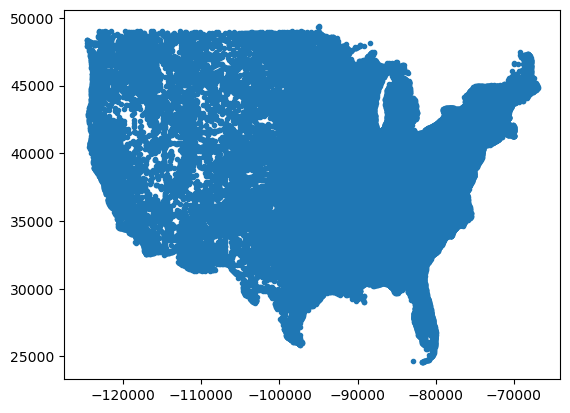

In [19]:
with open("cities.csv") as datafile:
    data = np.loadtxt(datafile, delimiter=" ")[:,1:] # chop of city indices

N = len(data)

CITIES = np.zeros((N,2))
CITIES[:,0] = -data[:,1]
CITIES[:,1] = data[:,0]

plt.plot(CITIES[:,0],CITIES[:,1],'.');

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


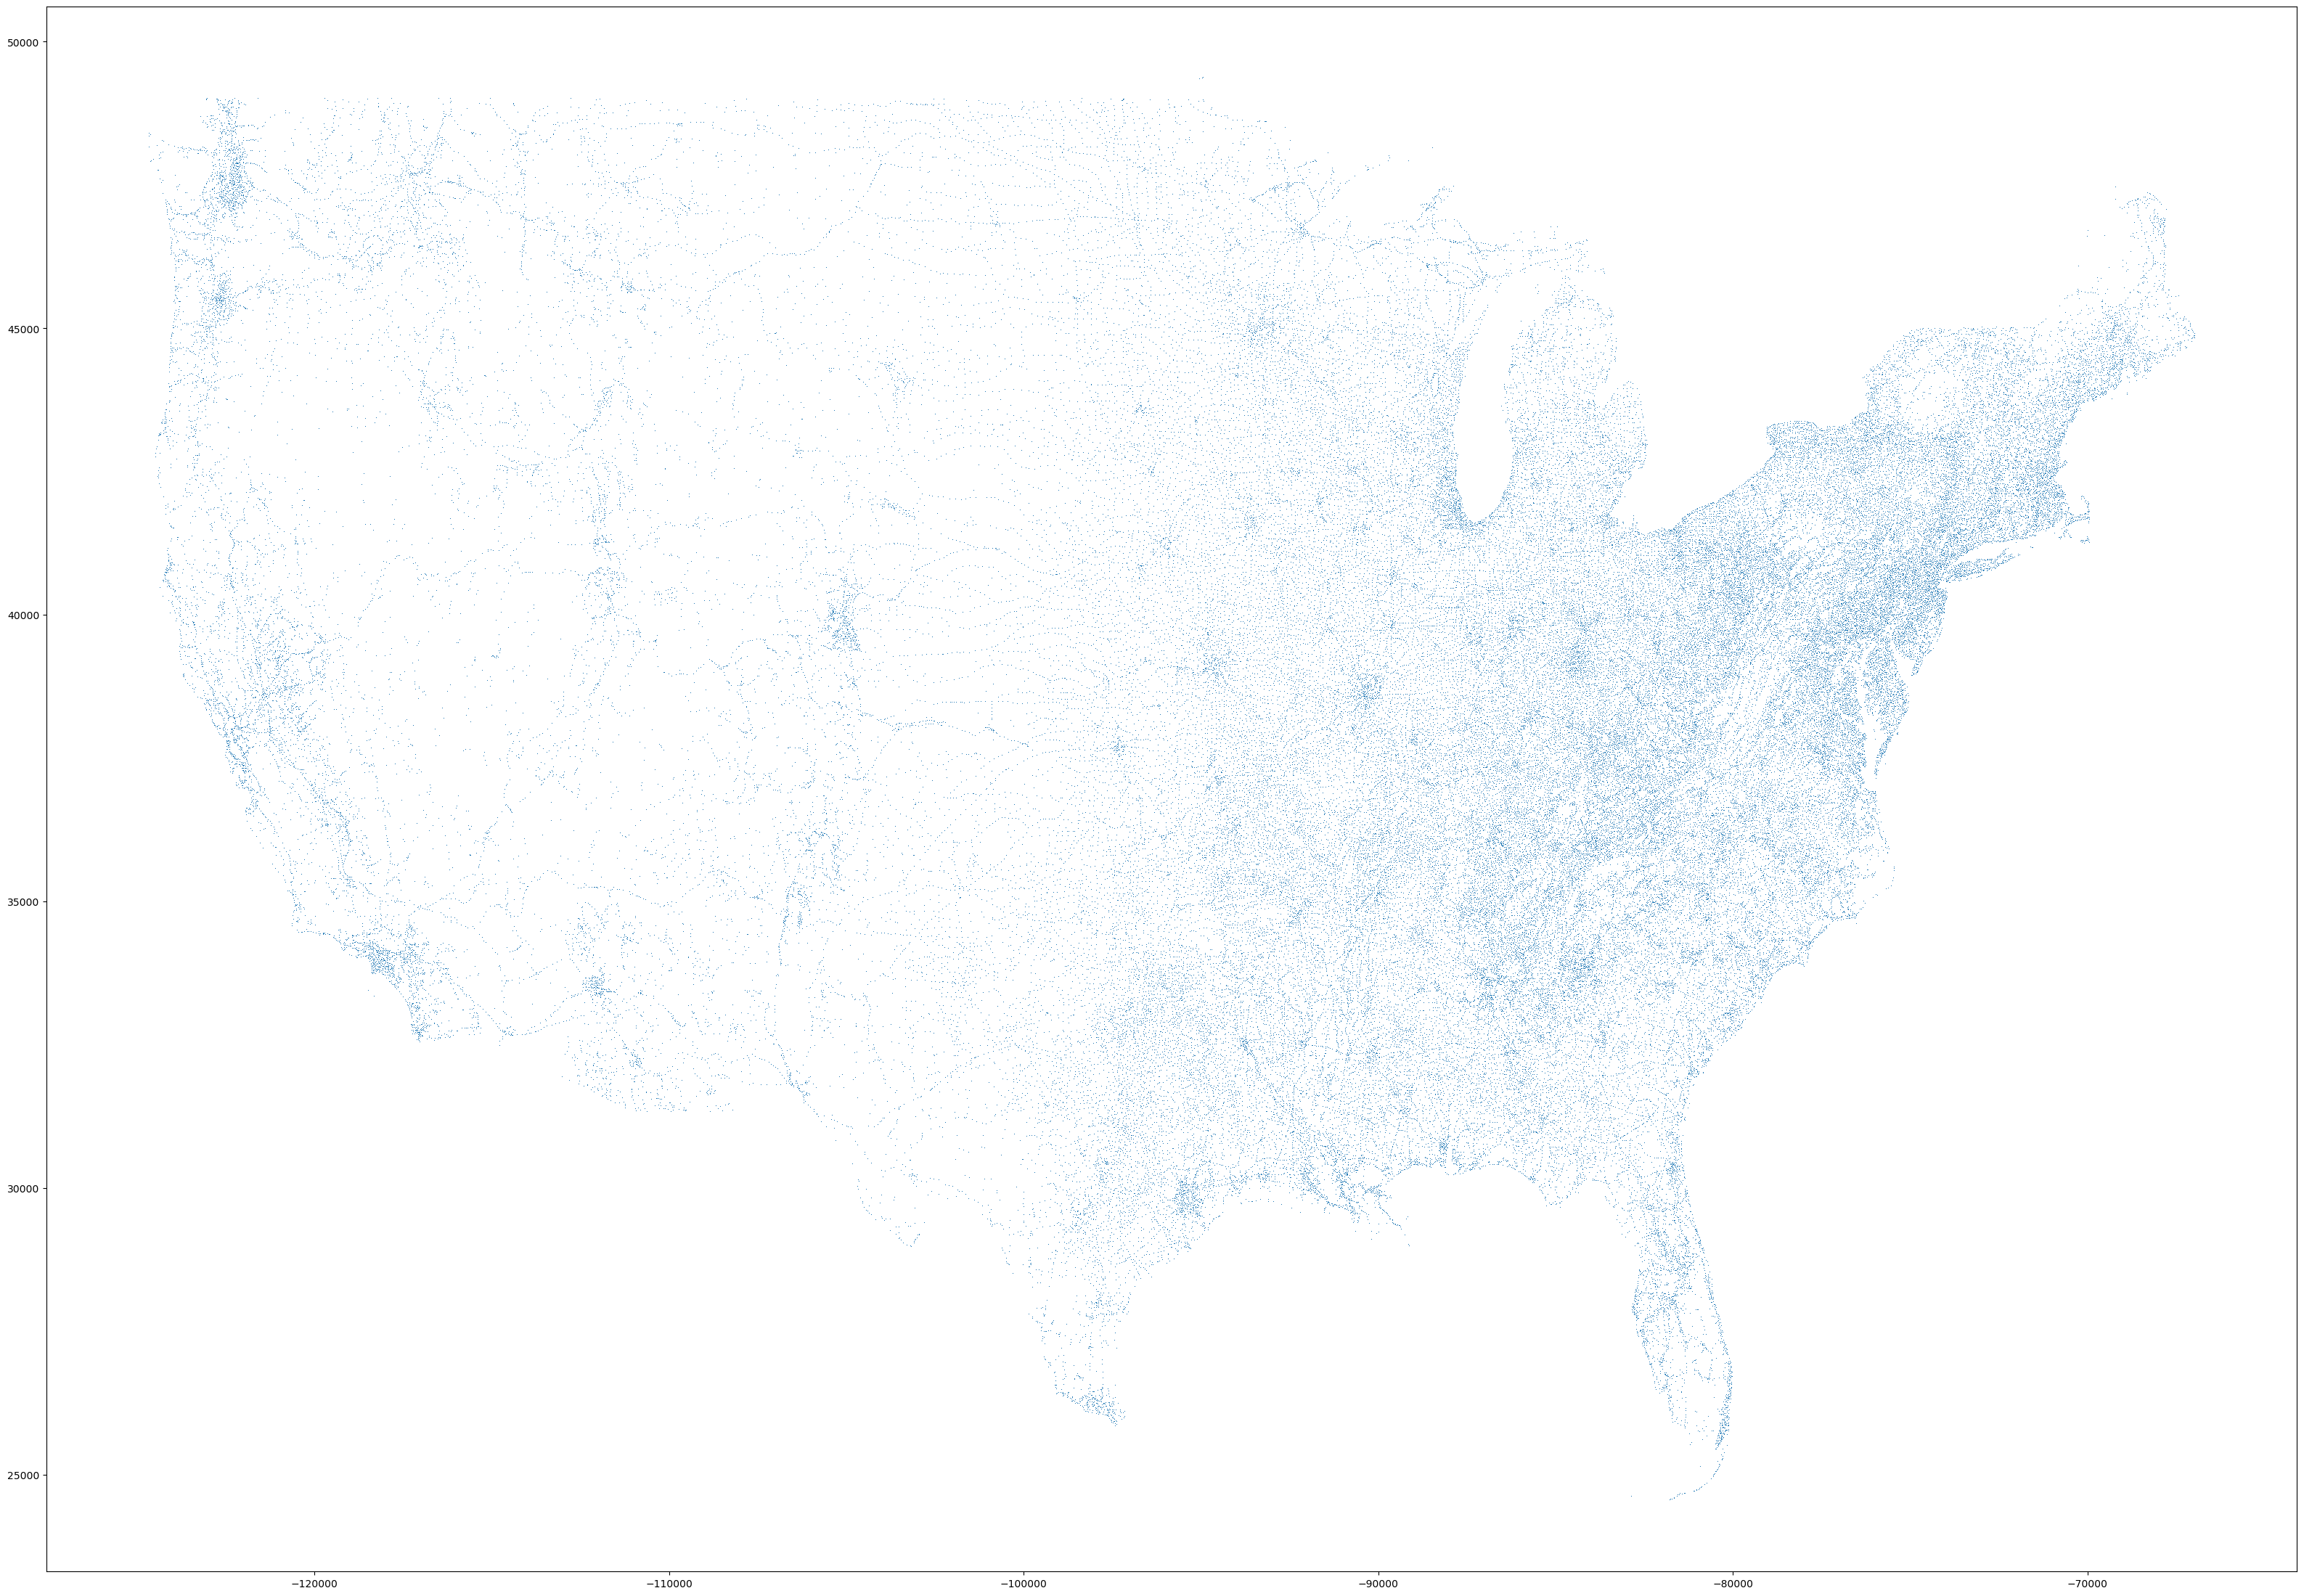

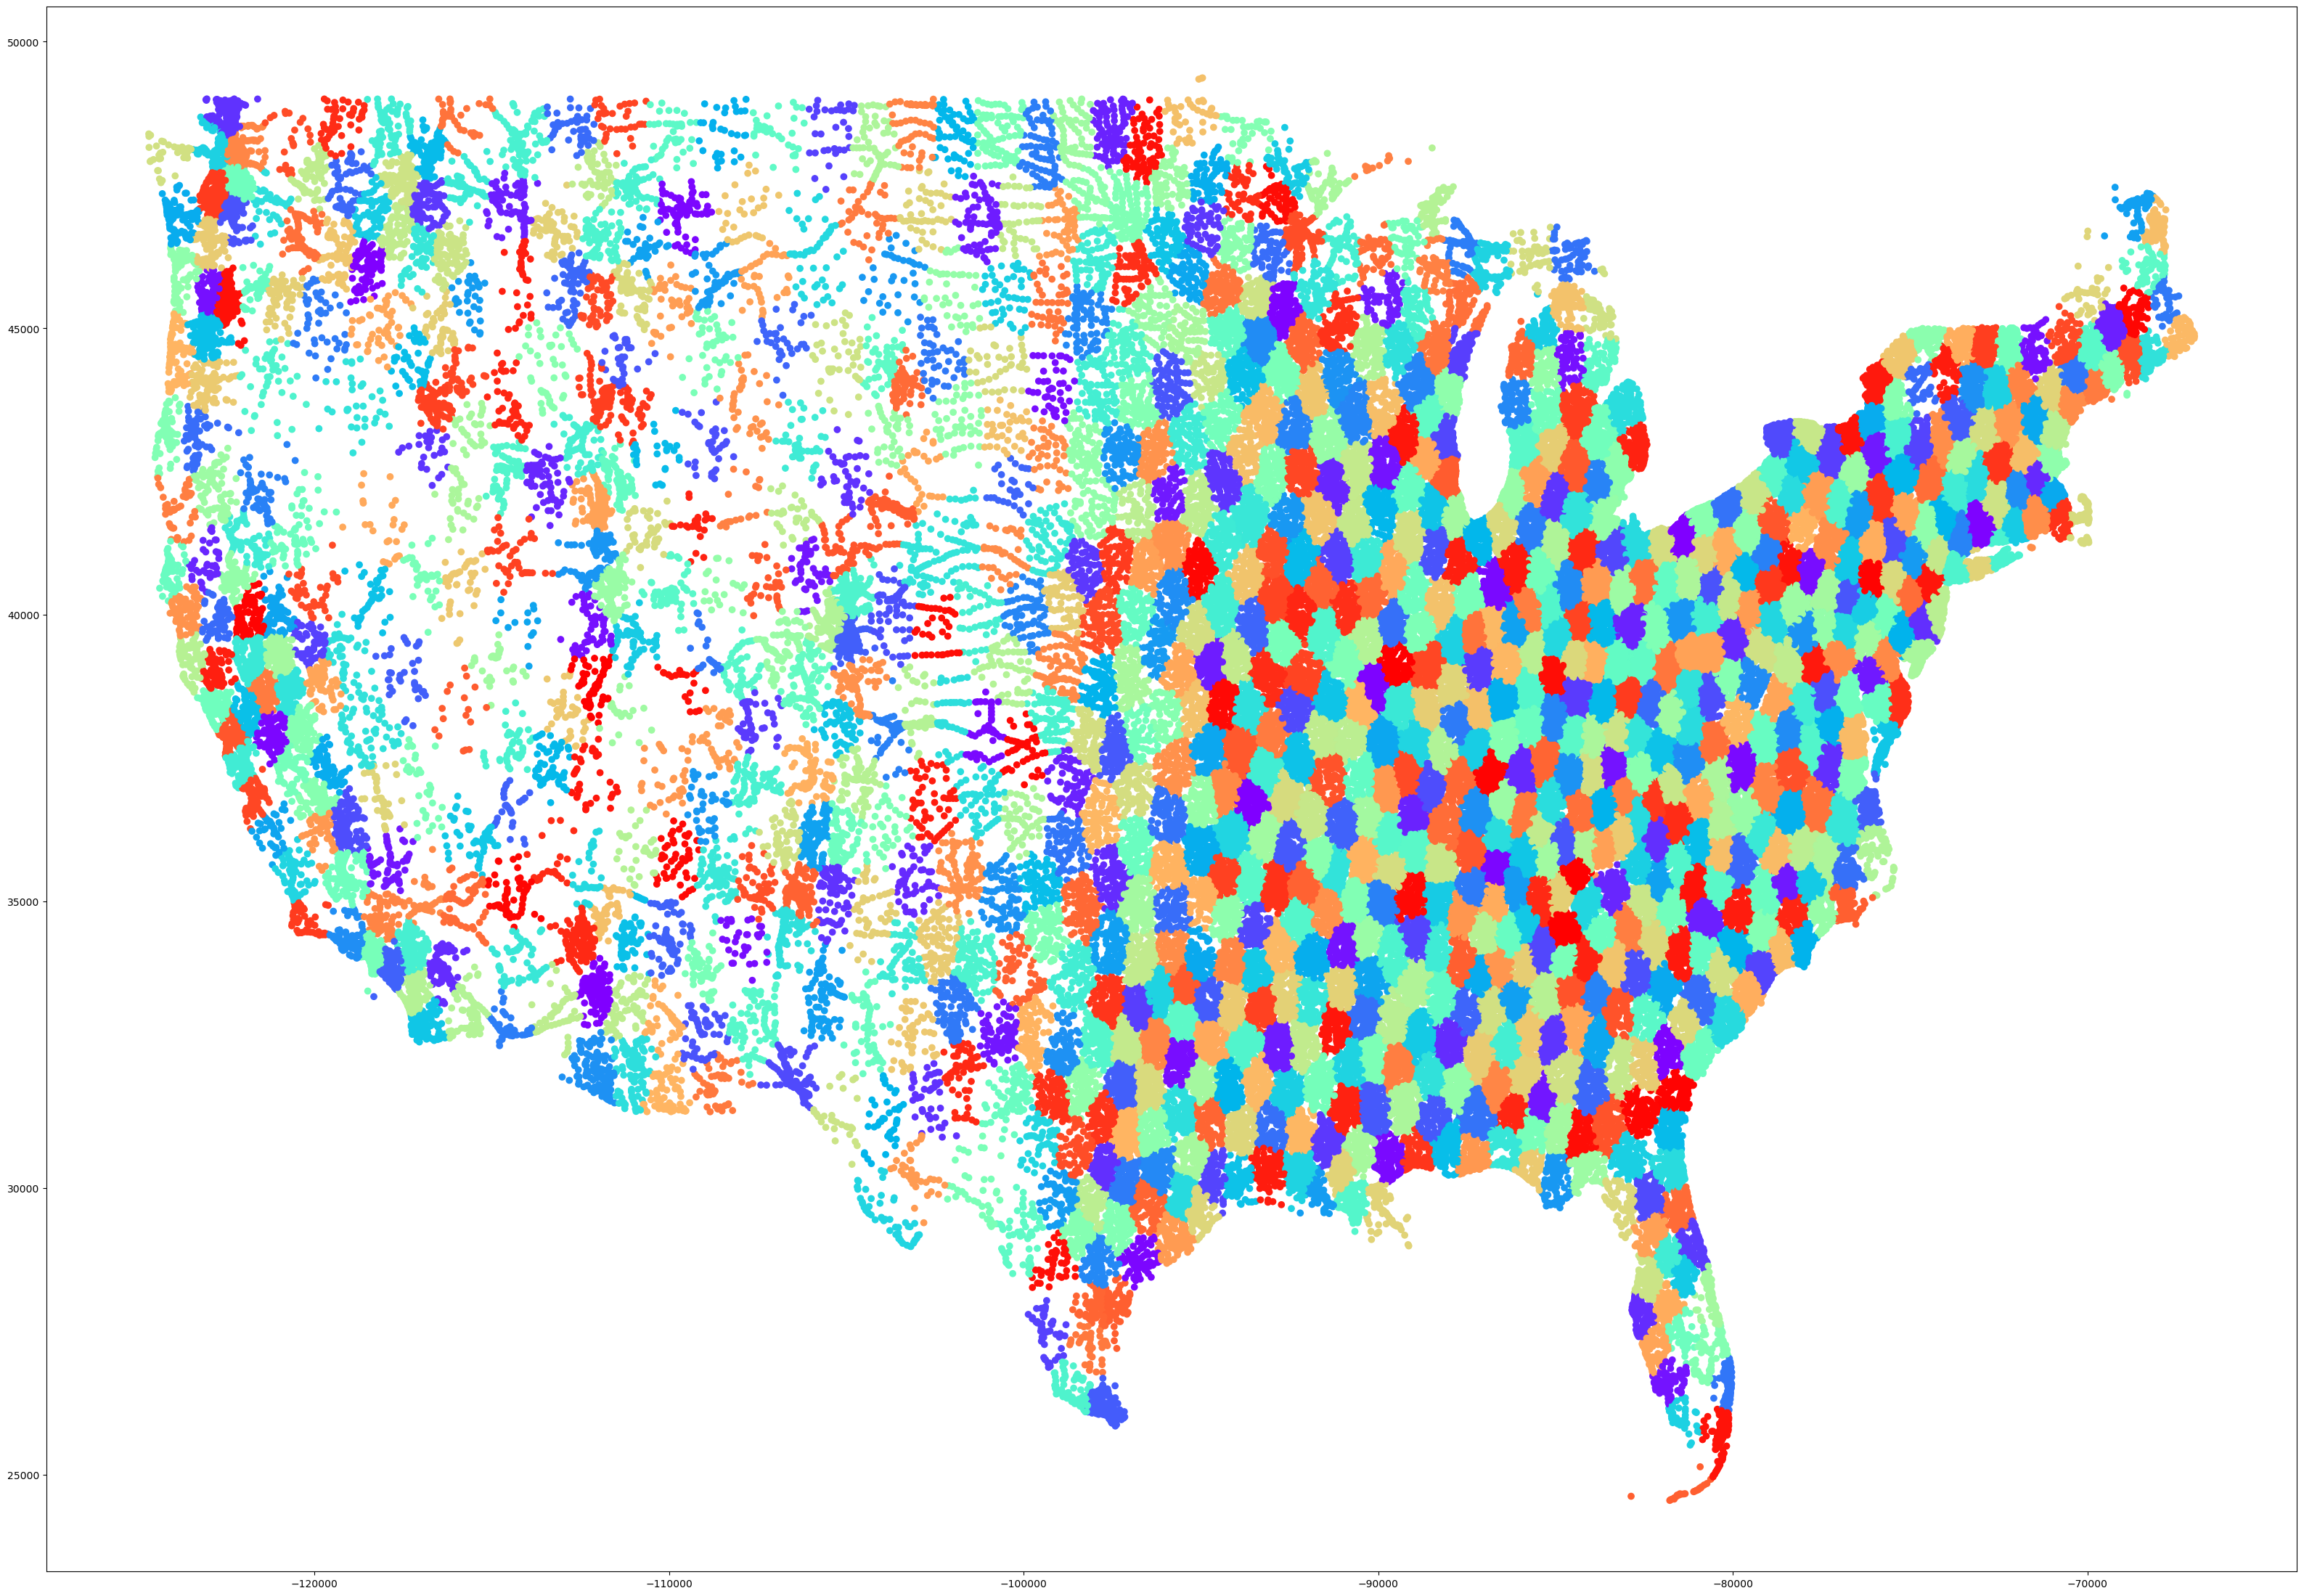

In [20]:
CITIES = np.zeros((N,2))
CITIES[:,0] = -data[:,1]
CITIES[:,1] = data[:,0]

means = 1000
plt.figure(figsize=(40,28), dpi=100)
plt.plot(CITIES[:,0],CITIES[:,1], ',');
kmeans = KMeans(n_clusters=means)
kmeans.fit(CITIES)
plt.figure(figsize=(40,28),dpi=100)
plt.scatter(CITIES[:,0],CITIES[:,1], c=kmeans.labels_, cmap='rainbow')
plt.show()

In [21]:
neighborhood_indexes = []
neighborhood_coords = []
for i in range(means):
    neighborhood_indexes.append(np.array([]))
    neighborhood_coords.append([])
for i in range(len(CITIES)):
    neighborhood_indexes[kmeans.labels_[i]] = np.append(neighborhood_indexes[kmeans.labels_[i]], i)
    neighborhood_coords[kmeans.labels_[i]].append(CITIES[i])

In [22]:
#print(neighborhood_coords[0])
print(len(neighborhood_coords[0]))

229


In [23]:
def dist(city_i,city_j):
    return math.sqrt((city_i[0]-city_j[0])**2 + (city_i[1]-city_j[1])**2)

# assuming order is a permutation of the integers {0,...,N-1}, calculate associated tour length
def tour_length(cities,tour):
    n = len(cities)
    length = 0
    for i in range(1,n): # add dist(i-1,i)
        length += dist(cities[tour[i-1],:],cities[tour[i],:])
    return length + dist(cities[tour[0],:],cities[tour[n-1],:])

# swaps two values in arr, based on the indices specified by pair
def swap(arr,pair):
    o_i = arr[pair[0]]
    arr[pair[0]]=arr[pair[1]]
    arr[pair[1]]=o_i

# checks that no single swap improves the given tour
def is_local_opt(cities,tour):
    curr = tour_length(cities,tour)
    for i in range(1,len(cities)):
        for j in range(1,i):
            p=(i,j)
            swap(tour,p)
            if tour_length(cities,tour)<curr:
                return False
            swap(tour,p)
    return True

# print the distance if visiting cities in the order 0,2,...,N-1,0
print("Length of in-order tour of",len(CITIES),"cities:",tour_length(CITIES,np.array(range(len(CITIES)))))
print("Is locally optimal?",is_local_opt(CITIES,np.array(range(len(CITIES)))))

Length of in-order tour of 115475 cities: 213920969.00611648
Is locally optimal? False


In [24]:
total_average=[]
for i in range(means):
    neighborhood = i
    average=neighborhood_coords[neighborhood][0]
    total=[0,0]
    for j in range(len(neighborhood_coords[neighborhood])):
        total+=neighborhood_coords[neighborhood][j]
        average=total/len(neighborhood_coords[neighborhood])
    total_average.append(average)



In [25]:
q=0
order=[total_average[0]]
start = total_average[0]
copy_average=[]
for i in range(len(total_average)):
    copy_average.append(total_average[i])
copy_average.pop(0)
final_length=0
for j in range(means-1):
    l=100000
    for i in range(len(copy_average)):
        d = dist(start, copy_average[i])
        if (d<l and d != 0):
            l = d
            close = copy_average[i]
            q=i
    start = close
    order.append(copy_average[q])
    del copy_average[q]




In [26]:
order_indexes=[]
for j in range (means):
    for i in range (len(order)):
        if(order[j][0] == total_average[i][0] and order[j][1] == total_average[i][1]):
            order_indexes.append(i)
print(order_indexes[:5])

[0, 666, 444, 588, 680]


In [27]:
final_tour=[]
def node(p):
    neighborhood = p

    n_cities = len(neighborhood_coords[neighborhood])
    distance = np.zeros((n_cities,n_cities))
    iteration = 20
    n_ants = n_cities

    def dist(city_i,city_j):
        return math.sqrt((city_i[0]-city_j[0])**2 + (city_i[1]-city_j[1])**2)


    m = n_ants
    n = n_cities
    e = .5         #evaporation rate
    alpha = 1      #pheromone factor
    beta = 2       #visibility factor



    pheromne = .1*np.ones((m,n))

    route = np.ones((m,n+1))
    for i in range(n_cities):
        for j in range(n_cities):
          distance[i][j] = dist(neighborhood_coords[neighborhood][i],neighborhood_coords[neighborhood][j])


    master_visibility = 1/distance
    master_visibility[master_visibility == inf ] = 0


    for it in range(iteration):
        route[:,0] = 1
        for i in range(m):
            temp_visibility = np.array(master_visibility)
            for j in range(n-1):

                combine_feature = np.zeros(100)
                cum_prob = np.zeros(100)

                cur_loc = int(route[i,j]-1)

                temp_visibility[:,cur_loc] = 0

                p_feature = np.power(pheromne[cur_loc,:],beta)
                v_feature = np.power(temp_visibility[cur_loc,:],alpha)


                combine_feature = np.multiply(p_feature,v_feature)
                total = np.sum(combine_feature)
                probs = combine_feature/total

                cum_prob = np.cumsum(probs)
                r = np.random.random_sample()
                city = np.nonzero(cum_prob>r)[0][0]+1

                route[i,j+1] = city


        route_opt = np.array(route)
        dist_cost = np.zeros((m,1))

        for i in range(m):
            s = 0

            for j in range(n-1):
                s = s + distance[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1]
            dist_cost[i]=s

        dist_min_loc = np.argmin(dist_cost)
        dist_min_cost = dist_cost[dist_min_loc]

        best_route = route[dist_min_loc,:]
        pheromne = (1-e)*pheromne

        for i in range(m):
            for j in range(n-1):
                dt = 1/dist_cost[i]
                pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] = pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] + dt

    length = int(dist_min_cost[0])
    for i in range(len(route_opt)):
        final_tour.append(neighborhood_coords[p][int(best_route[i])-1])
    return length

In [28]:
for l in range(means):
    final_length+=node(order_indexes[l])
#This is not the actual final length. That is lower

/var/folders/8q/jzwt9rrs4bz6txvcy6scnyn80000gn/T/ipykernel_69534/4143105949.py:30: RuntimeWarning: divide by zero encountered in divide
  master_visibility = 1/distance


In [29]:
best_tour=np.zeros((len(final_tour), 2))
print(len(final_tour))
for i in range(len(best_tour)):
    best_tour[i][0]=final_tour[i][0]
    best_tour[i][1]=final_tour[i][1]
print(best_tour[:5])

115475
[[-81410.9468  41413.1094]
 [-81386.5008  41413.9426]
 [-81386.5012  41436.1644]
 [-81365.3887  41431.4422]
 [-81338.1643  41411.7202]]


In [30]:
with open('final.txt', 'a') as fp:
    for i in best_tour:
        fp.write(str(i))
        fp.write(',')
        print('\n')

In [31]:
def tour_length(best_tour,tour):
    n = len(tour)
    length = 0
    for i in range(1,n): # add dist(i-1,i)
        length += dist(best_tour[int(tour[i-1]),:],best_tour[int(tour[i]),:])
    return length + dist(best_tour[int(tour[0]),:],best_tour[int(tour[n-1]),:])


# print the distance if visiting cities in the order 0,2,...,N-1,0
print("Length of in-order tour of",len(best_tour),"cities:",tour_length(best_tour,np.array(range(len(best_tour)))))

#This returns the distance of the best tour

Length of in-order tour of 115475 cities: 8892177.320318287
